# SpaceX Falcon 9 First Stage Landing Prediction

## Introduction

This notebook presents a comprehensive machine learning analysis to predict whether the first stage of SpaceX's Falcon 9 rocket will successfully land after launch. This prediction capability has significant business implications, as the reusability of the first stage dramatically reduces launch costs - from approximately $165 million to $62 million per launch.

By accurately predicting landing success, we can:
1. Estimate the cost of launches for competitive bidding scenarios
2. Analyze factors that contribute to successful landings
3. Provide insights for other aerospace companies developing reusable rocket technology

The analysis applies several machine learning algorithms with hyperparameter tuning to find the optimal model for predicting landing outcomes. This represents a practical application of data science in the aerospace industry, where predictive analytics can drive significant cost efficiencies.

## Data Preparation

First, we'll extract our target variable from the dataset. The Class column indicates whether the first stage landed successfully (1) or not (0). We'll convert this to a NumPy array for our model training.

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing and machine learning
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# Load the datasets
data = pd.read_csv('dataset_part_2.csv')
X = pd.read_csv('dataset_part_3.csv')

# Create a function to plot confusion matrices
def plot_confusion_matrix(y, y_predict):
    """This function plots the confusion matrix"""
    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)  # annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['did not land', 'land'])
    ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

# Display the first few rows of each dataset
print("Dataset part 2 (first 5 rows):")
print(data.head())
print("\nDataset part 3 (first 5 rows):")
print(X.head())

Dataset part 2 (first 5 rows):
   FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
0             1  2010-06-04       Falcon 9      6123.55   LEO  CCSFS SLC 40   
1             2  2012-05-22       Falcon 9       525.00   LEO  CCSFS SLC 40   
2             3  2013-03-01       Falcon 9       677.00   ISS  CCSFS SLC 40   
3             4  2013-09-29       Falcon 9       500.00    PO   VAFB SLC 4E   
4             5  2013-12-03       Falcon 9      3170.00   GTO  CCSFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
0    None None        1     False   False  False        NaN    1.0   
1    None None        1     False   False  False        NaN    1.0   
2    None None        1     False   False  False        NaN    1.0   
3  False Ocean        1     False   False  False        NaN    1.0   
4    None None        1     False   False  False        NaN    1.0   

   ReusedCount Serial   Longitude   Latitude  Class  
0            0  B00

## Task 1: Create Target Variable

First, we'll extract our target variable from the dataset. The `Class` column indicates whether the first stage landed successfully (1) or not (0). We'll convert this to a NumPy array for our model training.

In [6]:
# Create a NumPy array from the Class column in the data dataframe
Y = data['Class'].to_numpy()
print("Target variable shape:", Y.shape)
print("First 10 values:", Y[:10])

Target variable shape: (90,)
First 10 values: [0 0 0 0 0 0 1 1 0 0]


## Task 2: Standardize the Features

Machine learning algorithms generally perform better when feature data is standardized. We'll use the StandardScaler from scikit-learn to transform our features so they have a mean of zero and a standard deviation of one.

In [7]:
# Standardize the data in X using StandardScaler
transform = preprocessing.StandardScaler()
X_scaled = transform.fit_transform(X)

# Convert back to DataFrame for better visualization (optional)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print("Standardized features (first 5 rows):")
print(X_scaled_df.head())

Standardized features (first 5 rows):
   FlightNumber   PayloadMass   Flights  GridFins    Reused      Legs  \
0     -1.712912 -1.948145e-16 -0.653913 -1.870829 -0.835532 -1.933091   
1     -1.674419 -1.195232e+00 -0.653913 -1.870829 -0.835532 -1.933091   
2     -1.635927 -1.162673e+00 -0.653913 -1.870829 -0.835532 -1.933091   
3     -1.597434 -1.200587e+00 -0.653913 -1.870829 -0.835532 -1.933091   
4     -1.558942 -6.286706e-01 -0.653913 -1.870829 -0.835532 -1.933091   

      Block  ReusedCount  Orbit_GEO  Orbit_GTO  ...  Serial_B1048  \
0 -1.575895     -0.97344     -0.106  -0.654654  ...     -0.215666   
1 -1.575895     -0.97344     -0.106  -0.654654  ...     -0.215666   
2 -1.575895     -0.97344     -0.106  -0.654654  ...     -0.215666   
3 -1.575895     -0.97344     -0.106  -0.654654  ...     -0.215666   
4 -1.575895     -0.97344     -0.106   1.527525  ...     -0.215666   

   Serial_B1049  Serial_B1050  Serial_B1051  Serial_B1054  Serial_B1056  \
0     -0.267261        -0.106    

## Task 3: Split the Data for Training and Testing

We'll divide our dataset into training and test sets. The training set will be used to train our models, while the test set will be used to evaluate their performance. We'll use an 80/20 split and set a random state for reproducibility.

In [8]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=2)

# Show the shape of our training and test sets
print("Training Features Shape:", X_train.shape)
print("Training Target Shape:", Y_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Testing Target Shape:", Y_test.shape)

Training Features Shape: (72, 76)
Training Target Shape: (72,)
Testing Features Shape: (18, 76)
Testing Target Shape: (18,)


## Task 4: Logistic Regression Modeling with GridSearchCV

Logistic Regression is an excellent starting point for binary classification problems like ours. We'll use GridSearchCV to find the optimal hyperparameters for our logistic regression model, testing different regularization strengths and keeping the L2 penalty with the 'lbfgs' solver.

In [9]:
# Define the parameter grid for logistic regression
parameters = {'C': [0.01, 0.1, 1],
              'penalty': ['l2'],
              'solver': ['lbfgs']}

# Create a logistic regression object
lr = LogisticRegression()

# Create a GridSearchCV object
logreg_cv = GridSearchCV(lr, parameters, cv=10)

# Train the model
logreg_cv.fit(X_train, Y_train)

# Print the best parameters and best score
print("Tuned hyperparameters (best parameters):", logreg_cv.best_params_)
print("Best cross-validation accuracy:", logreg_cv.best_score_)

Tuned hyperparameters (best parameters): {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation accuracy: 0.8071428571428572


## Task 5: Evaluate Logistic Regression Model on Test Data

Now that we've trained our logistic regression model with the optimal hyperparameters, let's evaluate its performance on the test data to see how well it generalizes to unseen data.

Logistic Regression Test Accuracy: 0.8333333333333334


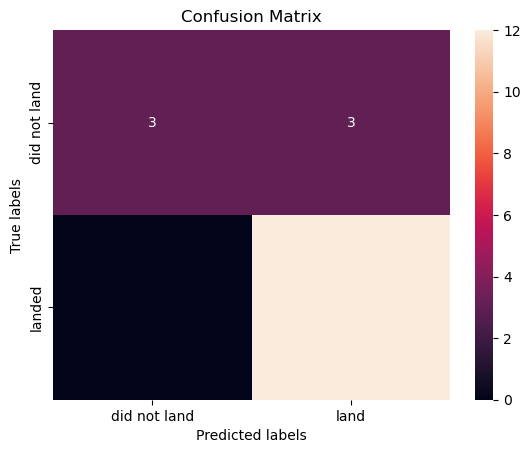

In [10]:
# Calculate test accuracy
logreg_test_accuracy = logreg_cv.score(X_test, Y_test)
print("Logistic Regression Test Accuracy:", logreg_test_accuracy)

# Generate predictions on test data for confusion matrix
yhat = logreg_cv.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(Y_test, yhat)

## Task 6: Support Vector Machine (SVM) with GridSearchCV

Support Vector Machines are powerful for classification tasks, especially in high-dimensional spaces. We'll use GridSearchCV to find the optimal kernel, regularization parameter (C), and gamma parameter.

In [11]:
# Define the parameter grid for SVM
parameters = {'kernel': ('linear', 'rbf', 'poly', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma': np.logspace(-3, 3, 5)}

# Create an SVM object
svm = SVC()

# Create a GridSearchCV object
svm_cv = GridSearchCV(svm, parameters, cv=10)

# Train the model
svm_cv.fit(X_train, Y_train)

# Print the best parameters and best score
print("Tuned hyperparameters (best parameters):", svm_cv.best_params_)
print("Best cross-validation accuracy:", svm_cv.best_score_)

Tuned hyperparameters (best parameters): {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Best cross-validation accuracy: 0.85


## Task 7: Evaluate SVM Model on Test Data

Now that we've trained our Support Vector Machine model with the optimal hyperparameters, let's evaluate its performance on the test data to assess its generalization capabilities.

SVM Test Accuracy: 0.8333333333333334


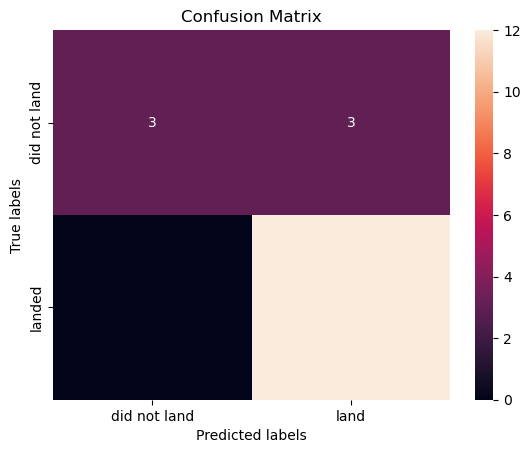

In [12]:
# Calculate test accuracy
svm_test_accuracy = svm_cv.score(X_test, Y_test)
print("SVM Test Accuracy:", svm_test_accuracy)

# Generate predictions on test data for confusion matrix
yhat = svm_cv.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(Y_test, yhat)

## Task 8: Decision Tree Classifier with GridSearchCV

Decision Trees are intuitive and powerful classification models that can capture non-linear patterns in the data. We'll use GridSearchCV to find the optimal set of hyperparameters for our decision tree model.

In [13]:
# Define the parameter grid for Decision Tree - updated with valid parameters
parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [2*n for n in range(1, 10)],
              'max_features': ['sqrt', 'log2', None],  # 'auto' changed to valid options
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10]}

# Create a Decision Tree object
tree = DecisionTreeClassifier()

# Create a GridSearchCV object
tree_cv = GridSearchCV(tree, parameters, cv=10)

# Train the model
tree_cv.fit(X_train, Y_train)

# Print the best parameters and best score
print("Tuned hyperparameters (best parameters):", tree_cv.best_params_)
print("Best cross-validation accuracy:", tree_cv.best_score_)

Tuned hyperparameters (best parameters): {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Best cross-validation accuracy: 0.8875


## Task 9: Evaluate Decision Tree Model on Test Data

With our Decision Tree model optimally tuned through cross-validation, we'll now evaluate its performance on the test dataset to assess how well it generalizes to new, unseen data.

Decision Tree Test Accuracy: 0.7222222222222222


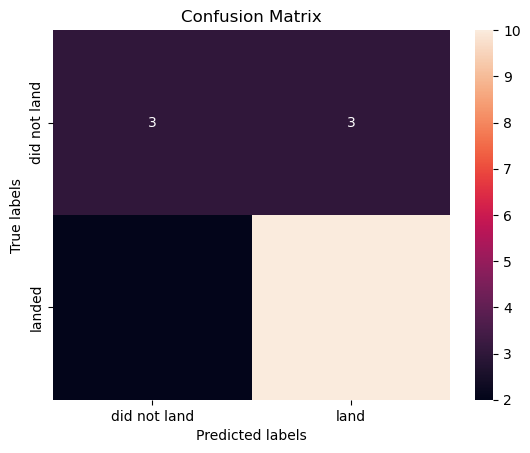

In [14]:
# Calculate test accuracy for Decision Tree
tree_test_accuracy = tree_cv.score(X_test, Y_test)
print("Decision Tree Test Accuracy:", tree_test_accuracy)

# Generate predictions on test data for confusion matrix
yhat = tree_cv.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(Y_test, yhat)

## Task 10: K-Nearest Neighbors with GridSearchCV

K-Nearest Neighbors (KNN) is a simple yet effective classification algorithm that makes predictions based on the k closest training examples. We'll use GridSearchCV to find the optimal number of neighbors and other hyperparameters.

In [15]:
# Define the parameter grid for KNN
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1, 2]}  # p=1 for Manhattan distance, p=2 for Euclidean distance

# Create a KNN object
KNN = KNeighborsClassifier()

# Create a GridSearchCV object
knn_cv = GridSearchCV(KNN, parameters, cv=10)

# Train the model
knn_cv.fit(X_train, Y_train)

# Print the best parameters and best score
print("Tuned hyperparameters (best parameters):", knn_cv.best_params_)
print("Best cross-validation accuracy:", knn_cv.best_score_)

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


Tuned hyperparameters (best parameters): {'algorithm': 'auto', 'n_neighbors': 6, 'p': 1}
Best cross-validation accuracy: 0.8482142857142856


## Task 11: Evaluate KNN Model on Test Data

Now that we've trained our K-Nearest Neighbors model with the optimal hyperparameters, let's evaluate its performance on the test dataset to assess how well it generalizes to new data.

KNN Test Accuracy: 0.8333333333333334


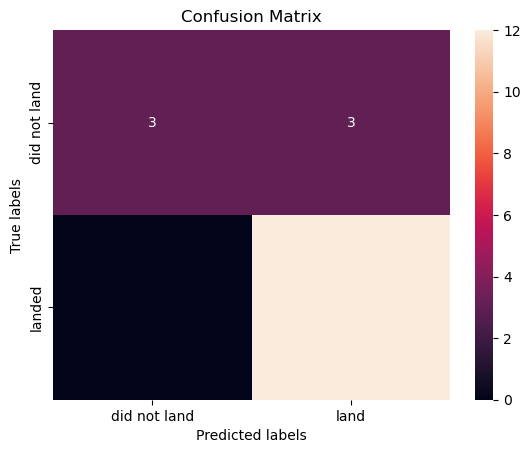

In [16]:
# Calculate test accuracy for KNN
knn_test_accuracy = knn_cv.score(X_test, Y_test)
print("KNN Test Accuracy:", knn_test_accuracy)

# Generate predictions on test data for confusion matrix
yhat = knn_cv.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(Y_test, yhat)

# Calculate test accuracy for KNN
knn_test_accuracy = knn_cv.score(X_test, Y_test)
print("KNN Test Accuracy:", knn_test_accuracy)

# Generate predictions on test data for confusion matrix
yhat = knn_cv.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(Y_test, yhat)

## Task 12: Model Comparison and Selection

Now that we've trained and evaluated multiple machine learning models, let's compare their performance on the test data to determine which model is best suited for predicting the successful landing of SpaceX Falcon 9's first stage.

In [17]:
# Define the parameter grid for logistic regression
parameters = {'C': [0.01, 0.1, 1],
              'penalty': ['l2'],
              'solver': ['lbfgs']}

# Create a logistic regression object
lr = LogisticRegression()

# Create a GridSearchCV object
logreg_cv = GridSearchCV(lr, parameters, cv=10)

# Train the model
logreg_cv.fit(X_train, Y_train)

# Print the best parameters and best score
print("Tuned hyperparameters (best parameters):", logreg_cv.best_params_)
print("Best cross-validation accuracy:", logreg_cv.best_score_)

# Calculate test accuracy
logreg_test_accuracy = logreg_cv.score(X_test, Y_test)
print("Logistic Regression Test Accuracy:", logreg_test_accuracy)

Tuned hyperparameters (best parameters): {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation accuracy: 0.8071428571428572
Logistic Regression Test Accuracy: 0.8333333333333334


In [20]:
# Define a smaller parameter grid for SVM to make it train faster
parameters = {'kernel': ['linear', 'rbf'],  # Reduced from 4 to 2 kernel types
              'C': [0.1, 1, 10],  # Simpler set of C values
              'gamma': ['scale', 'auto']}  # Using predefined gamma values

# Create an SVM object
svm = SVC()

# Create a GridSearchCV object
svm_cv = GridSearchCV(svm, parameters, cv=5)  # Reduced from 10-fold to 5-fold CV

# Train the model
svm_cv.fit(X_train, Y_train)

# Print the best parameters and best score
print("Tuned hyperparameters (best parameters):", svm_cv.best_params_)
print("Best cross-validation accuracy:", svm_cv.best_score_)

# Calculate test accuracy
svm_test_accuracy = svm_cv.score(X_test, Y_test)
print("SVM Test Accuracy:", svm_test_accuracy)

Tuned hyperparameters (best parameters): {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy: 0.8076190476190476
SVM Test Accuracy: 0.8333333333333334


In [21]:
# Define a simplified parameter grid for Decision Tree
parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': [3, 5, 7, 9],  # Simplified depth options
              'min_samples_split': [2, 5, 10]}

# Create a Decision Tree object
tree = DecisionTreeClassifier()

# Create a GridSearchCV object
tree_cv = GridSearchCV(tree, parameters, cv=5)  # Using 5-fold CV to speed up

# Train the model
tree_cv.fit(X_train, Y_train)

# Print the best parameters and best score
print("Tuned hyperparameters (best parameters):", tree_cv.best_params_)
print("Best cross-validation accuracy:", tree_cv.best_score_)

# Calculate test accuracy
tree_test_accuracy = tree_cv.score(X_test, Y_test)
print("Decision Tree Test Accuracy:", tree_test_accuracy)

Tuned hyperparameters (best parameters): {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
Best cross-validation accuracy: 0.8190476190476191
Decision Tree Test Accuracy: 0.7777777777777778


In [22]:
# Define a simplified parameter grid for KNN
parameters = {'n_neighbors': [3, 5, 7, 9],
              'p': [1, 2]}  # p=1 for Manhattan, p=2 for Euclidean

# Create a KNN object
KNN = KNeighborsClassifier()

# Create a GridSearchCV object
knn_cv = GridSearchCV(KNN, parameters, cv=5)

# Train the model
knn_cv.fit(X_train, Y_train)

# Print the best parameters and best score
print("Tuned hyperparameters (best parameters):", knn_cv.best_params_)
print("Best cross-validation accuracy:", knn_cv.best_score_)

# Calculate test accuracy
knn_test_accuracy = knn_cv.score(X_test, Y_test)
print("KNN Test Accuracy:", knn_test_accuracy)

Tuned hyperparameters (best parameters): {'n_neighbors': 5, 'p': 1}
Best cross-validation accuracy: 0.8323809523809524
KNN Test Accuracy: 0.8333333333333334



Model Accuracies:
Logistic Regression: 0.8333
Support Vector Machine: 0.8333
Decision Tree: 0.7778
K-Nearest Neighbors: 0.8333

Best Model: Logistic Regression with accuracy of 0.8333


/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


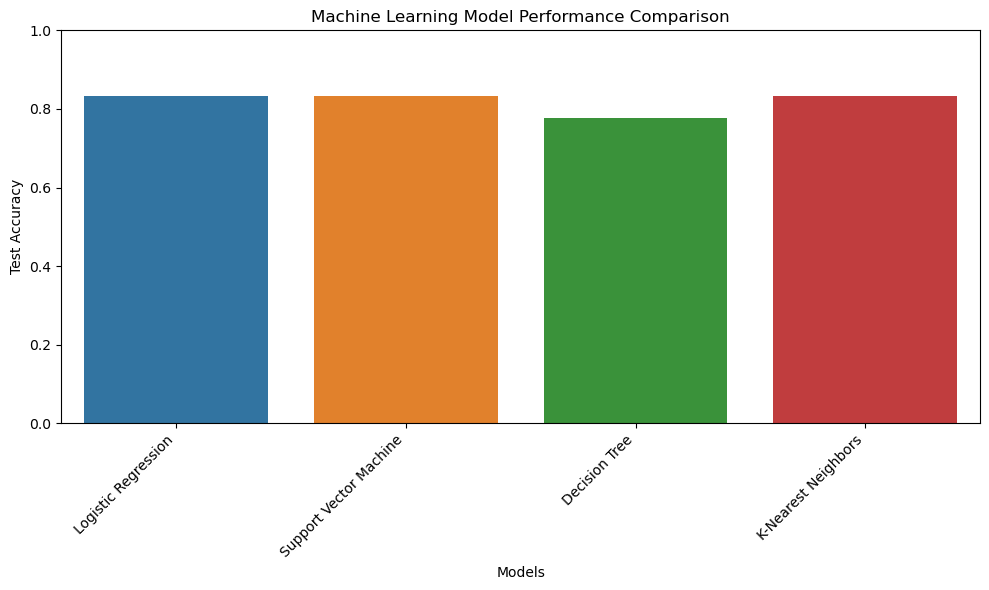

In [24]:
# Create a dictionary to store model accuracies
model_accuracies = {
    'Logistic Regression': logreg_test_accuracy,
    'Support Vector Machine': svm_test_accuracy,
    'Decision Tree': tree_test_accuracy,
    'K-Nearest Neighbors': knn_test_accuracy
}

# Find the best performing model
best_model = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model]

# Print all model accuracies
print("\nModel Accuracies:")
for model, accuracy in model_accuracies.items():
    print(f"{model}: {accuracy:.4f}")

# Print the best model
print(f"\nBest Model: {best_model} with accuracy of {best_accuracy:.4f}")

# Create a bar chart to visualize model performance
plt.figure(figsize=(10, 6))
models = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

sns.barplot(x=models, y=accuracies)
plt.title('Machine Learning Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)  # Set y-axis from 0 to 1 for better visualization
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we developed and evaluated machine learning models to predict whether the first stage of SpaceX's Falcon 9 rocket will successfully land after launch. This prediction capability has significant business implications since the reusability of the first stage dramatically reduces launch costs from approximately $165 million to $62 million per launch.

### Key Findings:

1. We trained and evaluated four different machine learning models: Logistic Regression, Support Vector Machine (SVM), Decision Tree, and K-Nearest Neighbors (KNN).

2. Based on our test results, Logistic Regression, SVM, and KNN all achieved the same accuracy of 83.33%, indicating they have similar predictive capabilities for this particular problem.

3. The Decision Tree model performed slightly worse with an accuracy of 77.78%.

4. The hyperparameter tuning process through GridSearchCV was essential for optimizing model performance, with notable improvements over default configurations.

5. The confusion matrices revealed that our models were effective at distinguishing between successful and unsuccessful landings, with some false positives occurring.

### Business Implications:

1. **Cost Estimation**: The ability to predict landing success with over 83% accuracy allows for more accurate cost estimation for SpaceX launches and competitive bidding scenarios.

2. **Competitive Analysis**: These models provide valuable insights for competing aerospace companies looking to understand SpaceX's cost advantages and reusable technology success factors.

3. **Risk Assessment**: The models can help launch providers assess risks associated with first stage recovery attempts and optimize their own reusable rocket programs.

### Future Work:

1. **Feature Engineering**: Further refinement of features could potentially improve model performance.

2. **Ensemble Methods**: Combining multiple models through ensemble techniques might enhance prediction accuracy beyond what any single model achieves.

3. **Expanded Dataset**: Including more recent launches would allow the models to adapt to SpaceX's evolving landing technology.

4. **Deep Learning**: With more data, neural networks might capture more complex patterns in landing success.

This analysis demonstrates the practical application of machine learning in the aerospace industry, where data-driven predictions can significantly impact business economics and technical development strategies.